In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.multioutput import MultiOutputRegressor
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# ==========================================
# 기초 함수 및 강화된 피처 엔지니어링 정의
# ==========================================

def add_all_year_holiday_features(data):
    def get_flower_holidays(year):
        return {
            'Graduation': pd.to_datetime(f'{year}-02-10'),
            'Valentine': pd.to_datetime(f'{year}-02-14'),
            'WhiteDay': pd.to_datetime(f'{year}-03-14'),
            'ParentsDay': pd.to_datetime(f'{year}-05-08'),
            'TeachersDay': pd.to_datetime(f'{year}-05-15'),
            'Christmas': pd.to_datetime(f'{year}-12-25')
        }
    def calculate_min_dist(row):
        curr = row['date']
        hols = list(get_flower_holidays(curr.year).values()) + list(get_flower_holidays(curr.year + 1).values())
        future = [h for h in hols if h >= curr]
        if not future: return 0
        dist = (min(future) - curr).days
        return max(0, 14 - dist) if dist <= 14 else 0
    data['holiday_impact'] = data.apply(calculate_min_dist, axis=1)
    return data

def engineer_features(df):
    epsilon = 1e-6
    # 시장 구조 피처
    df["spread"] = df["max_amount"] - df["min_amount"]
    df["premium_ratio"] = df["max_amount"] / (df["mean"] + epsilon)
    df["low_pressure"] = df["mean"] - df["min_amount"]

    # [핵심] 차기 회차 물량 배치 (사용자 고찰 반영)
    df['next_auction_qty'] = df['total_quantity'].shift(-1)
    df['next_auction_qty'] = df['next_auction_qty'].fillna(df['total_quantity'].mean())
    df["next_qty_change_ratio"] = (df["next_auction_qty"] - df["total_quantity"]) / (df["total_quantity"] + epsilon)

    # 추세 피처
    df["mean_roll7_mean"] = df["mean"].rolling(7).mean()
    df["qty_roll7_mean"] = df["total_quantity"].rolling(7).mean()

    # 날짜 피처
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df = add_all_year_holiday_features(df)
    
    df = df.fillna(method='bfill').fillna(0)
    
    # 로그 변환 리스트 (next_auction_qty 포함)
    log_cols = ['max_amount', 'mean', 'min_amount', 'spread', 'total_quantity', 'next_auction_qty']
    for col in log_cols:
        df[f'log_{col}'] = np.log1p(df[col])
        
    return df

In [3]:
# ==========================================
# 2. 데이터 로드 및 연속형 멀티 타겟 데이터셋 생성
# ==========================================

df = pd.read_csv('../data/19_25_Q2freesia_sol.CSV')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['year'] = df['date'].dt.year
df['auction_count'] = df.groupby('year').cumcount() + 1

df_std = engineer_features(df)
min_rounds = df_std[df_std['year'] <= 2024].groupby('year')['auction_count'].max().min()
df_std = df_std[df_std['auction_count'] <= min_rounds].copy()

# 학습 피처 리스트 (강화 버전)
features = [
    'log_total_quantity', 'log_next_auction_qty', 'next_qty_change_ratio',
    'log_max_amount', 'log_mean', 'log_min_amount', 'log_spread', 
    'premium_ratio', 'low_pressure', 'mean_roll7_mean', 'qty_roll7_mean',
    'holiday_impact', 'auction_count', 'month', 'dayofweek'
]

C:\Users\ktg08\AppData\Local\Temp\ipykernel_23608\659266630.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(0)


In [4]:
def create_continuous_multi_target_dataset(data, window, steps, features):
    X, y, years, rounds = [], [], [], []
    for i in range(len(data) - window - steps + 1):
        X.append(data[features].iloc[i : i + window].values.flatten())
        y_min = data['log_min_amount'].iloc[i + window : i + window + steps].values
        y_mean = data['log_mean'].iloc[i + window : i + window + steps].values
        y_max = data['log_max_amount'].iloc[i + window : i + window + steps].values
        y.append(np.concatenate([y_min, y_mean, y_max]))
        years.append(data['year'].iloc[i + window])
        rounds.append(data['auction_count'].iloc[i + window])
    return np.array(X), np.array(y), np.array(years), np.array(rounds)

In [5]:
window_size, future_steps = 3, 7
X_raw, y_raw, year_indices, round_indices = create_continuous_multi_target_dataset(df_std, window_size, future_steps, features)

flat_feature_names = [f"{f}_lag{lag}" for lag in range(window_size, 0, -1) for f in features]
X_final_df = pd.DataFrame(X_raw, columns=flat_feature_names)

X_train, y_train = X_final_df[year_indices <= 2024], y_raw[year_indices <= 2024]
X_test, y_test = X_final_df[year_indices == 2025], y_raw[year_indices == 2025]
test_rounds = round_indices[year_indices == 2025]

In [6]:
# 모델 학습 (3중 타겟)
# ==========================================

lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.03, num_leaves=15, max_depth=5, random_state=42, verbose=-1)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,"LGBMRegressor...2, verbose=-1)"
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,boosting_type,'gbdt'
,num_leaves,15
,max_depth,5
,learning_rate,0.03
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


In [7]:
# [추가] 2025년 테스트 데이터 검증 및 지표 산출
# ==========================================

# 1. 2025년 테스트 데이터 예측
y_pred_log_test = model.predict(X_test)

# 2. Reshape 및 역로그 변환 (Inverse Transform)
# Shape: (샘플 수, 3지표, 7일치)
y_test_res = y_test.reshape(-1, 3, future_steps)
y_pred_res = y_pred_log_test.reshape(-1, 3, future_steps)

# 실제 가격으로 복원 (Step 1: 바로 다음 경매일 기준)
actual_min = np.expm1(y_test_res[:, 0, 0])
actual_mean = np.expm1(y_test_res[:, 1, 0])
actual_max = np.expm1(y_test_res[:, 2, 0])

pred_min = np.expm1(y_pred_res[:, 0, 0])
pred_mean = np.expm1(y_pred_res[:, 1, 0])
pred_max = np.expm1(y_pred_res[:, 2, 0])

# 3. MAPE(Mean Absolute Percentage Error) 계산 함수
def calculate_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / (actual + 1e-6))) * 100

mape_min = calculate_mape(actual_min, pred_min)
mape_mean = calculate_mape(actual_mean, pred_mean)
mape_max = calculate_mape(actual_max, pred_max)

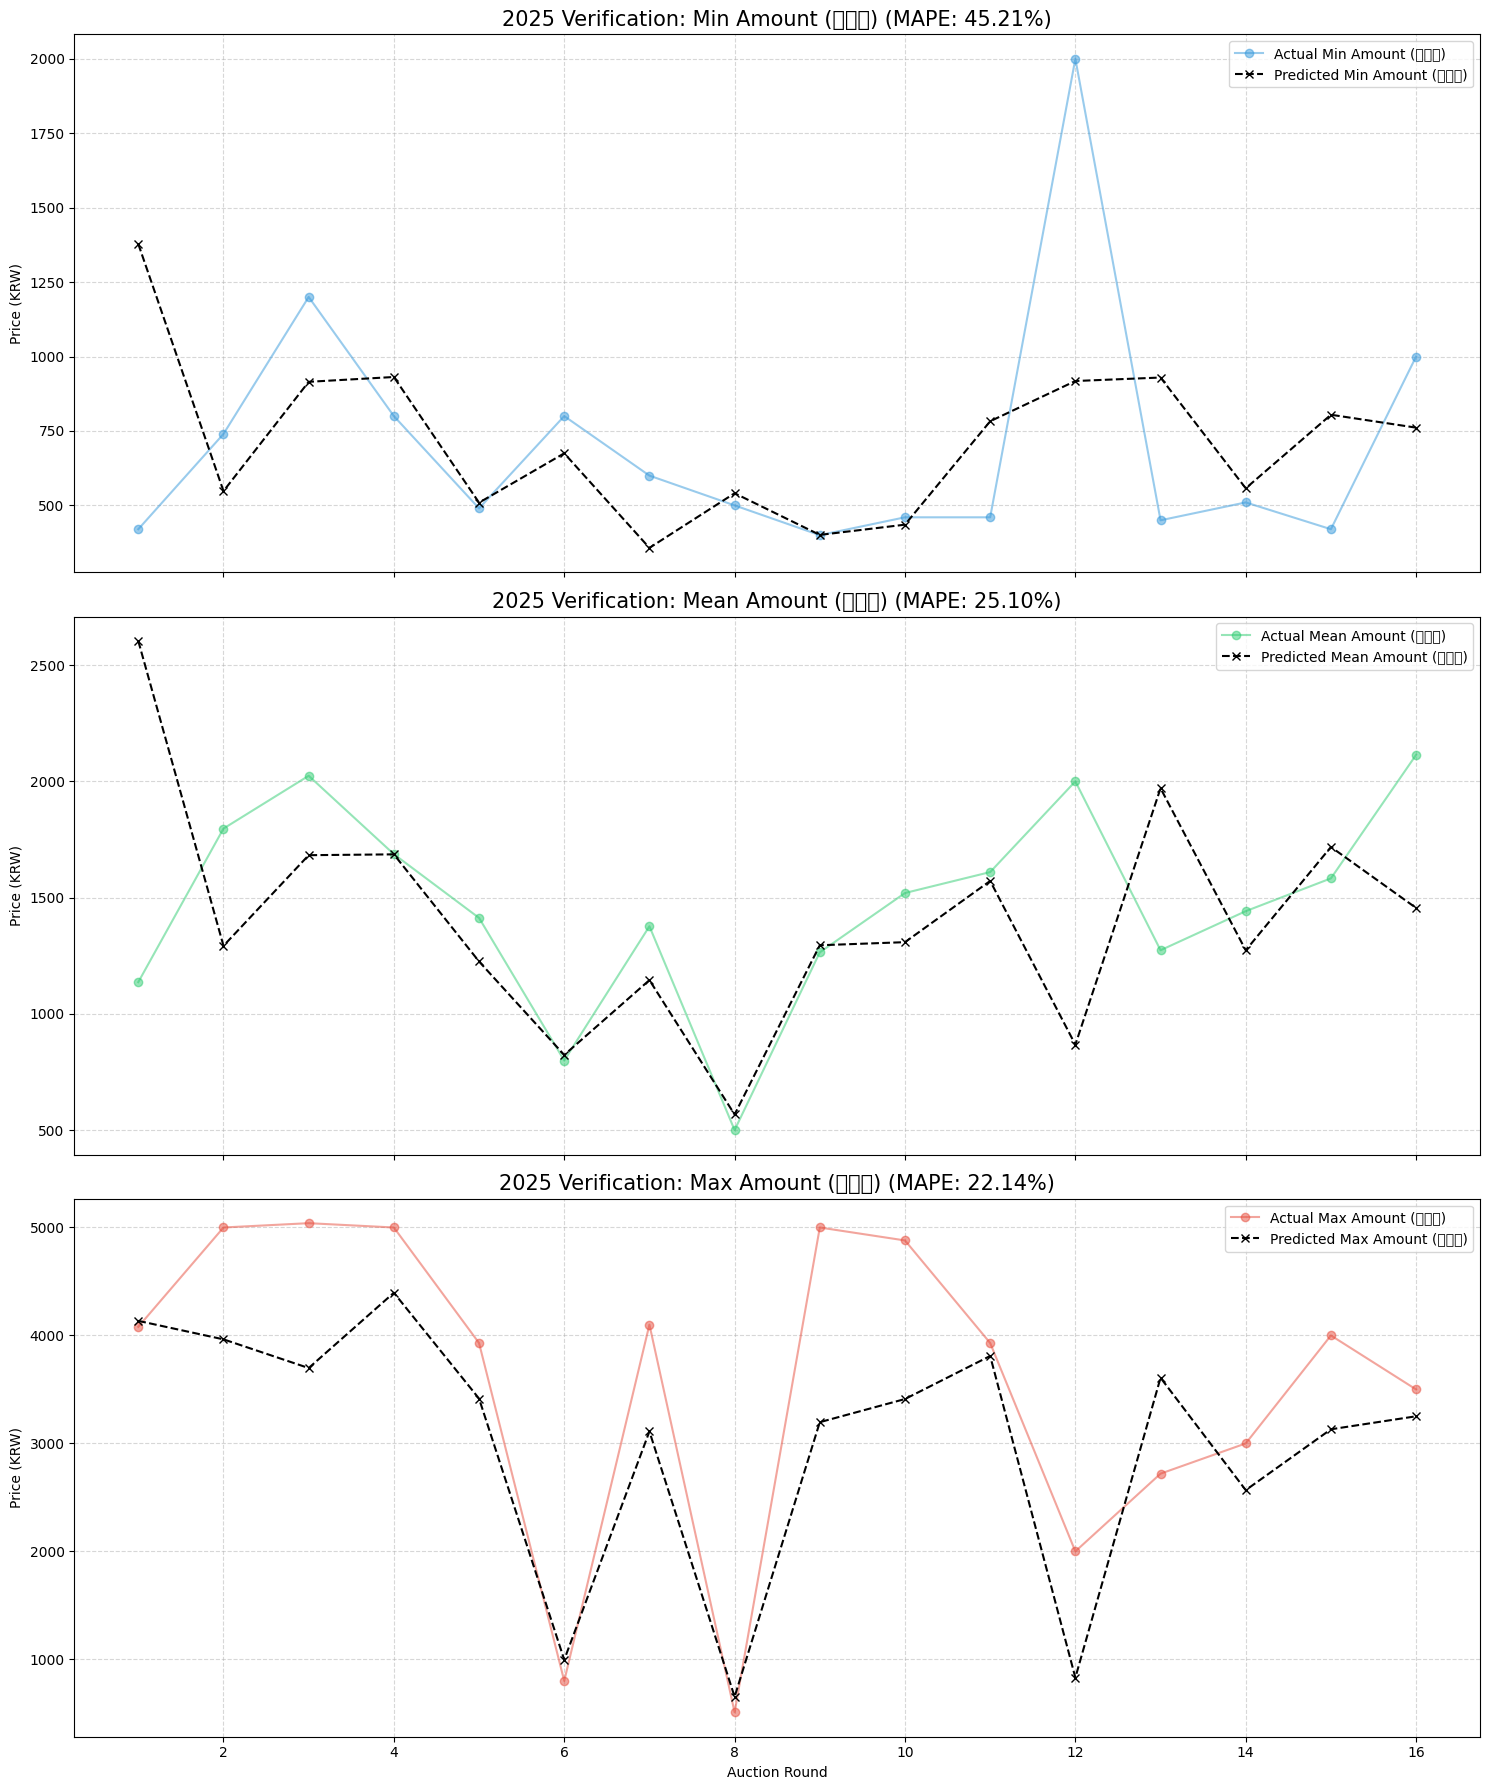

--- [2025년 모델 검증 지표 요약] ---
1. 최저가(Min) MAPE: 45.21%
2. 평균가(Mean) MAPE: 25.10%
3. 최고가(Max) MAPE: 22.14%


In [8]:
# 4. 시각화: 3개 지표 비교 그래프
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
titles = ['Min Amount (최저가)', 'Mean Amount (평균가)', 'Max Amount (최고가)']
actuals = [actual_min, actual_mean, actual_max]
preds = [pred_min, pred_mean, pred_max]
colors = ['#3498db', '#2ecc71', '#e74c3c'] # Blue, Green, Red
mapes = [mape_min, mape_mean, mape_max]

for i in range(3):
    axes[i].plot(test_rounds, actuals[i], 'o-', label=f'Actual {titles[i]}', color=colors[i], alpha=0.5)
    axes[i].plot(test_rounds, preds[i], 'x--', label=f'Predicted {titles[i]}', color='black', linewidth=1.5)
    
    axes[i].set_title(f"2025 Verification: {titles[i]} (MAPE: {mapes[i]:.2f}%)", fontsize=15)
    axes[i].set_ylabel("Price (KRW)")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Auction Round")
plt.tight_layout()
plt.show()

# 지표 요약 출력
print("--- [2025년 모델 검증 지표 요약] ---")
print(f"1. 최저가(Min) MAPE: {mape_min:.2f}%")
print(f"2. 평균가(Mean) MAPE: {mape_mean:.2f}%")
print(f"3. 최고가(Max) MAPE: {mape_max:.2f}%")

In [9]:
# ==========================================
# 3. 2026년 재귀적 예측 (Recursive Simulation)
# ==========================================
kr_holidays_2026 = [
    '2026-01-01', '2026-02-16', '2026-02-17', '2026-02-18', 
    '2026-03-02', '2026-05-05', '2026-05-25', '2026-08-17', 
    '2026-09-24', '2026-09-25', '2026-09-26', '2026-09-28', 
    '2026-10-05', '2026-10-09', '2026-12-25'
]

auc_cal_2026 = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2026)
start_date_2026 = pd.to_datetime('2026-01-02') 

# 회차별 평균 물량
avg_qty_by_round = df_std.groupby('auction_count')['total_quantity'].mean()

# 시작 윈도우 (2025년 마지막 3일)
current_x = df_std[df_std['year'] == 2025].tail(window_size)[features].values.flatten().tolist()
forecast_2026 = []

for r in range(1, min_rounds + 1):
    X_input = pd.DataFrame([current_x], columns=flat_feature_names)
    pred_log = model.predict(X_input)[0]
    
    # 결과 저장 (Min, Mean, Max)
    curr_date = start_date_2026 + ((r-1) * auc_cal_2026)
    forecast_2026.append({
        'date': curr_date, 'auction_count': r,
        'min': np.expm1(pred_log[0]), 'mean': np.expm1(pred_log[7]), 'max': np.expm1(pred_log[14])
    })
    
    # [핵심] 다음 회차를 위한 윈도우 업데이트 (내일 물량 정보 주입)
    if r < min_rounds:
        next_date = start_date_2026 + (r * auc_cal_2026)
        curr_qty = avg_qty_by_round.get(r, avg_qty_by_round.mean())
        next_qty = avg_qty_by_round.get(r+1, avg_qty_by_round.mean()) # 선행 물량 정보
        
        # 오늘 예측된 가격 로그값
        p_min, p_mean, p_max = pred_log[0], pred_log[7], pred_log[14]
        
        tmp_impact = add_all_year_holiday_features(pd.DataFrame({'date': [next_date]}))['holiday_impact'].iloc[0]
        
        next_row = [
            np.log1p(curr_qty), np.log1p(next_qty), (next_qty - curr_qty)/(curr_qty + 1e-6),
            p_max, p_mean, p_min, np.log1p(np.expm1(p_max)-np.expm1(p_min)),
            np.expm1(p_max)/(np.expm1(p_mean)+1e-6), np.expm1(p_mean)-np.expm1(p_min),
            p_mean, np.log1p(curr_qty), tmp_impact, r+1, next_date.month, next_date.dayofweek
        ]
        current_x = current_x[len(features):] + next_row


df_2026 = pd.DataFrame(forecast_2026)

C:\Users\ktg08\AppData\Local\Temp\ipykernel_23608\904765451.py:45: RuntimeWarning: invalid value encountered in log1p
  p_max, p_mean, p_min, np.log1p(np.expm1(p_max)-np.expm1(p_min)),


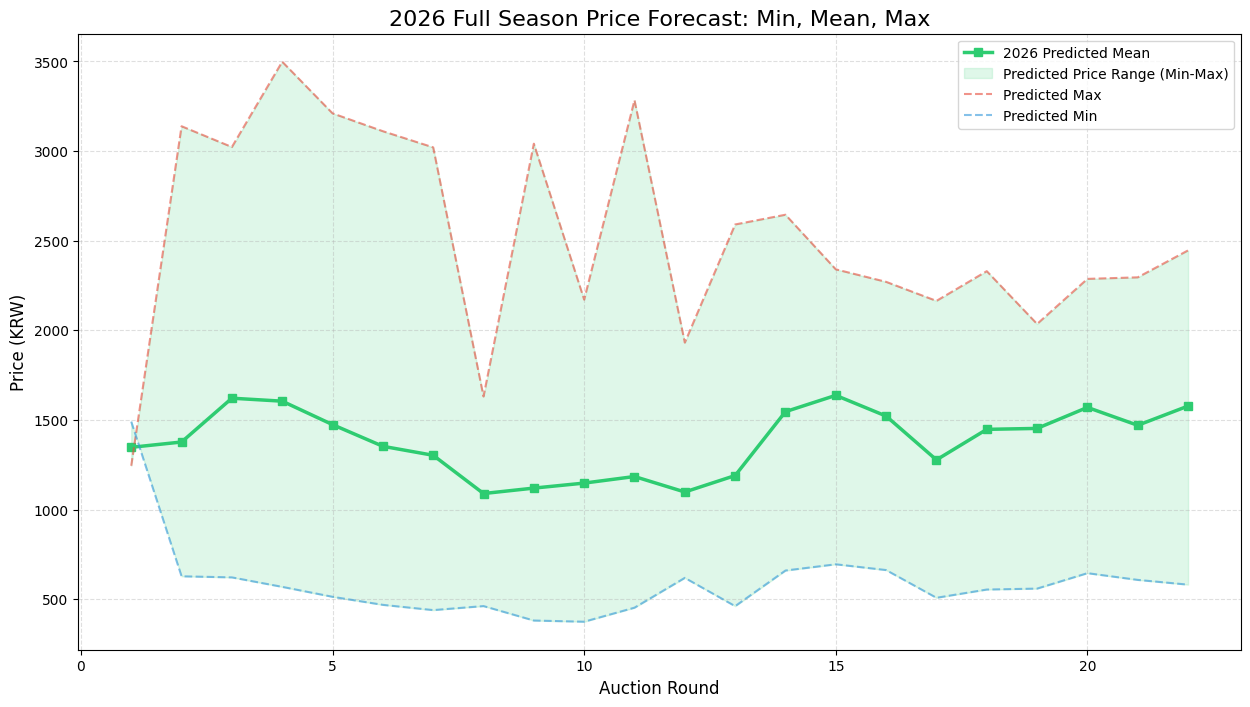

,date,auction_count,min,mean,max
0,2026-01-02,1,1490.821029,1347.595299,1244.642775
1,2026-01-05,2,628.119242,1377.184433,3138.562270
2,2026-01-07,3,622.085963,1621.593529,3022.601333
3,2026-01-09,4,569.225766,1605.023507,3498.491421
4,2026-01-12,5,513.769994,1474.197000,3210.448432
5,2026-01-14,6,468.843898,1353.349309,3110.861645
6,2026-01-16,7,439.566180,1303.153186,3020.757389
7,2026-01-19,8,461.990606,1089.775582,1631.049998
8,2026-01-21,9,381.393340,1120.118100,3041.242098
9,2026-01-23,10,374.758904,1148.028030,2171.325595


In [10]:
# 4. 2026년 예측 그래프 시각화 (Min, Mean, Max)
# ==========================================
plt.figure(figsize=(15, 8))

# 평균가 실선
plt.plot(df_2026['auction_count'], df_2026['mean'], 's-', label='2026 Predicted Mean', color='#2ecc71', linewidth=2.5)

# 최저/최고가 범위 (음영 처리)
plt.fill_between(df_2026['auction_count'], df_2026['min'], df_2026['max'], 
                 color='#2ecc71', alpha=0.15, label='Predicted Price Range (Min-Max)')

# 최저/최고가 점선
plt.plot(df_2026['auction_count'], df_2026['max'], '--', color='#e74c3c', alpha=0.6, label='Predicted Max')
plt.plot(df_2026['auction_count'], df_2026['min'], '--', color='#3498db', alpha=0.6, label='Predicted Min')

plt.title("2026 Full Season Price Forecast: Min, Mean, Max", fontsize=16)
plt.xlabel("Auction Round", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

display(df_2026[['date', 'auction_count', 'min', 'mean', 'max']].head(15))